In [25]:
import json
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display

In [26]:
photo_path = './photo/'
json_path = './json-data/'
train_path = './b_w_image/'
test_path = './test/'

# MSER based text region detection

## Detecting text region proposals

In [3]:
def get_text_region_proposals(image, min_area=300, max_area=3000, delta=3):
    mser = cv2.MSER_create()
    mser.setMinArea(min_area)
    mser.setMaxArea(max_area)
    mser.setDelta(delta)
    coordinates, _ = mser.detectRegions(image)    
    bbs = []
    for coord in coordinates:
        bbox = cv2.boundingRect(coord)
        x, y, w, h = bbox
        if w < 10 or h < 10 or w/h > 5 or h/w > 5:
            continue
        bbs.append((x, y, w, h))
    return bbs

In [4]:
image = cv2.imread(train_path+'183786.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

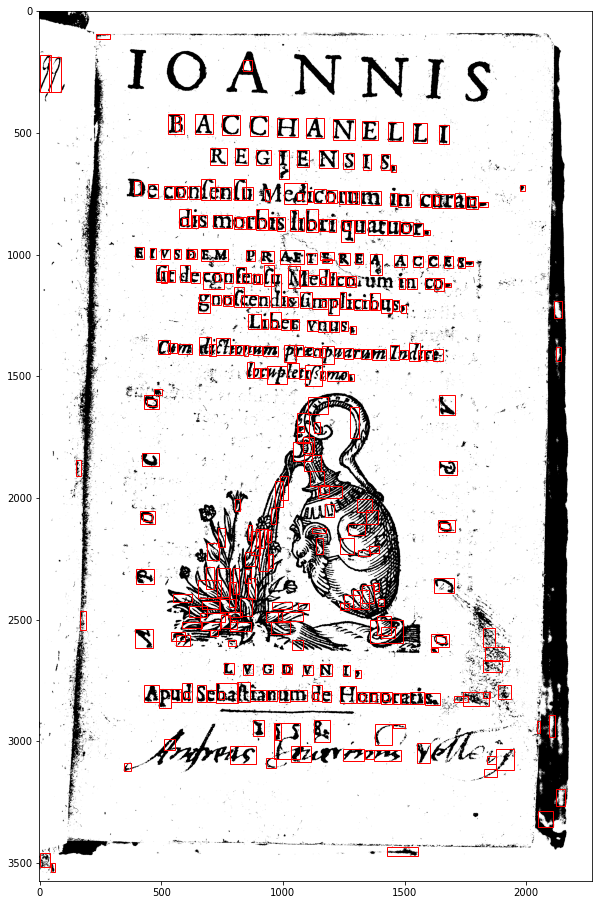

In [5]:
fig, ax = plt.subplots(1, figsize=(18, 16))
bbs = get_text_region_proposals(image)
ax.imshow(image, cmap='Greys_r')
for (x, y, w, h) in bbs:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    ax.add_patch(rect)
display.display(plt.gcf())
display.clear_output(wait=True)

## Detecting boundings of passages

In [6]:
def dilate_bbs(bbs, dilation_d, dilation_max):
    bbs_l = []
    for bb in bbs:
        (x, y, w, h) = bb
        (centre_x, centre_y) = (x + w/2, y + h/2)
        (x1, y1, x2, y2) = (x, y, x + w, y + h)

        dx = (centre_x - x1) * dilation_d
        dy = (centre_y - y1) * dilation_d
        
        if dilation_max:
            if dx > dilation_max[0]:
                dx = dilation_max[0]
            if dy > dilation_max[1]:
                dy = dilation_max[1]

        x1_l = centre_x - dx
        y1_l = centre_y - dy
        x2_l = centre_x + dx
        y2_l = centre_y + dy

        bb_l = (int(x1_l), int(y1_l), int(x2_l - x1_l), int(y2_l - y1_l))
        bbs_l.append(bb_l)
    return bbs_l

In [7]:
def does_rect_overlap(bb1, bb2):
    (x1_1, y1_1, w_1, h_1) = bb1
    (x1_1, y1_1, x2_1, y2_1) = (x1_1, y1_1, x1_1 + w_1, y1_1 + h_1)
    
    (x1_2, y1_2, w_2, h_2) = bb2
    (x1_2, y1_2, x2_2, y2_2) = (x1_2, y1_2, x1_2 + w_2, y1_2 + h_2)

    h_overlaps = True
    v_overlaps = True
    if (x1_1 > x2_2) or (x2_1 < x1_2):
        h_overlaps = False
    if (y1_1 > y2_2) or (y2_1 < y1_2):
        v_overlaps = False
    return h_overlaps and v_overlaps

In [8]:
def get_intersection_percentage(bb1, bb2):
    # How much of bb1 is intersecting with bb2
    if not does_rect_overlap(bb1, bb2):
        return 0

    (x1_1, y1_1, w_1, h_1) = bb1
    (x1_1, y1_1, x2_1, y2_1) = (x1_1, y1_1, x1_1 + w_1, y1_1 + h_1)
    
    (x1_2, y1_2, w_2, h_2) = bb2
    (x1_2, y1_2, x2_2, y2_2) = (x1_2, y1_2, x1_2 + w_2, y1_2 + h_2)

    x_a = max(x1_1, x1_2)
    y_a = max(y1_1, y1_2)
    x_b = min(x2_1, x2_2)
    y_b = min(y2_1, y2_2)

    inter_area = (x_b - x_a + 1) * (y_b - y_a + 1)

    bb1_area = (w_1 + 1) * (h_1 + 1)
    bb2_area = (w_2 + 1) * (h_2 + 1)

    intersection_percentage = inter_area / float(bb1_area)
    return intersection_percentage

In [9]:
def get_intersection_percentage_matrix(bbs):
    n = len(bbs)
    ip = np.zeros(shape=(n, n))
    for i in range(n):
        for j in range(n):
            ip[i, j] = get_intersection_percentage(bbs[i], bbs[j])
    return ip 

In [10]:
def make_new_bb_from_intersect_bbs(bbs):
    max_x = np.max([bb[0] + bb[2] for bb in bbs])
    min_x = np.min([bb[0] for bb in bbs])
    max_y = np.max([bb[1] + bb[3] for bb in bbs])
    min_y = np.min([bb[1] for bb in bbs])
    return (min_x, min_y, max_x - min_x, max_y - min_y)

In [11]:
def reduce_bbs_by_inetersection_percentage(bbs, in_matrix_thresholded):
    new_bbs = []
    for i in range(in_matrix_thresholded.shape[0]):
        in_i = in_matrix_thresholded[i, :]
        intersections_indexes = np.where(in_i)[0]
        if len(intersections_indexes) == 0:
            new_bbs.append(bbs[i])
        else:
            intersection_bbs = [bbs[i]]
            for intersections_index in intersections_indexes:
                intersection_bbs.append(bbs[intersections_index])
            new_bb = make_new_bb_from_intersect_bbs(intersection_bbs)
            if new_bb not in new_bbs:
                new_bbs.append(new_bb)
    return new_bbs

In [12]:
def reduce_intersecting_bbs(bbs, intersection_threshold):
    new_bbs = bbs
    while True:
        old_bbs_no = len(bbs)
        in_matrix = get_intersection_percentage_matrix(bbs)
        in_matrix_thresholded = in_matrix > intersection_threshold
        bbs = reduce_bbs_by_inetersection_percentage(bbs, in_matrix_thresholded)
        if old_bbs_no == len(bbs):
            break
    return bbs

In [13]:
def get_bounding_boxs_of_passages(bbs, iterations, ip_threshold, dilation_d, dilation_max=None, intermetiate_bbs=None):
    '''    
    Parameters
    ----------
    iterations: int

    ios_threshold: 

    dilation_d: float
        percentage to increase the bounding box

    '''
    for i in range(iterations):
        bbs = dilate_bbs(bbs, dilation_d, dilation_max)
        bbs = reduce_intersecting_bbs(bbs, ip_threshold)
        if intermetiate_bbs is not None:
            intermetiate_bbs.append(bbs)
        print("Running {}/{}, new #bbs {}".format(i, iterations, len(bbs)))
    return bbs

## Testing dilation

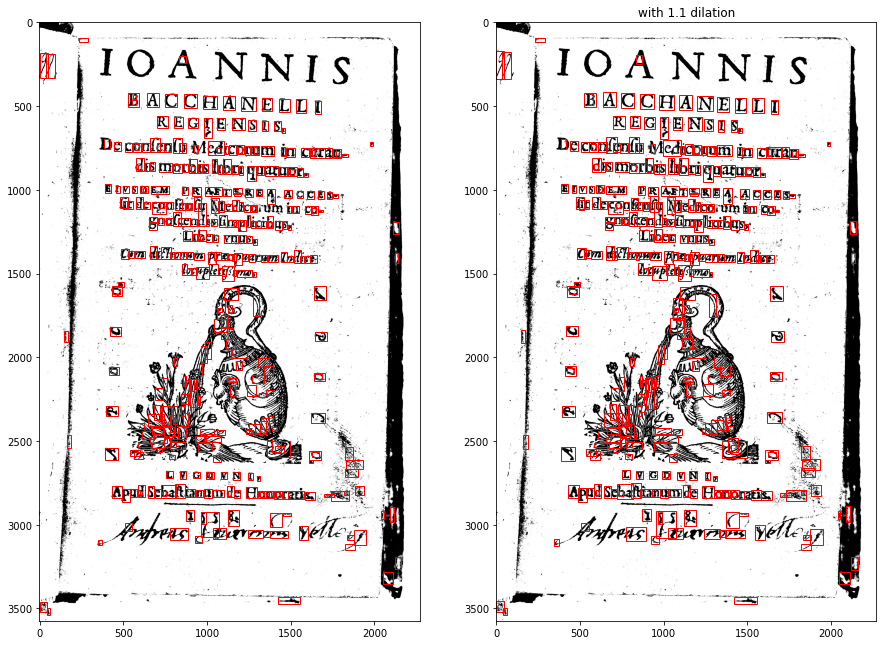

In [14]:
dilation_d = 1.1

bbs = get_text_region_proposals(image)
bbs_l = dilate_bbs(bbs, dilation_d, None)
fig, axs = plt.subplots(1, 2, figsize=(15, 13))

axs[0].imshow(image, cmap='Greys_r')
for (x, y, w, h) in bbs:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[0].add_patch(rect)
axs[1].imshow(image, cmap='Greys_r')
axs[1].set_title("with {} dilation".format(dilation_d))
for (x, y, w, h) in bbs_l:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[1].add_patch(rect)

## Testing intersections

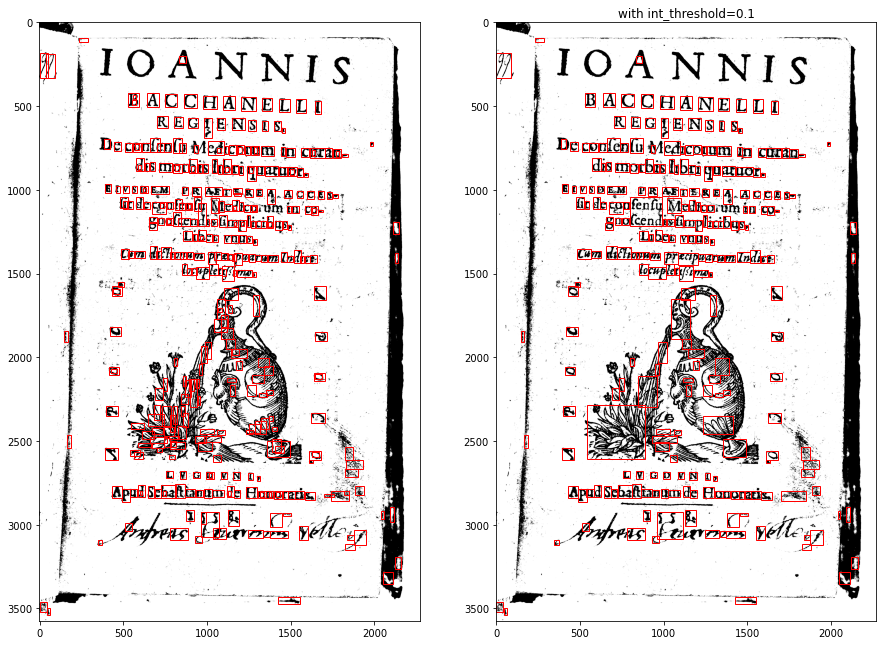

In [15]:
intersection_threshold = 0.1

bbs = get_text_region_proposals(image)
bbs_l = reduce_intersecting_bbs(bbs, intersection_threshold)

fig, axs = plt.subplots(1, 2, figsize=(15, 13))

axs[0].imshow(image, cmap='Greys_r')
for (x, y, w, h) in bbs:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[0].add_patch(rect)
axs[1].imshow(image, cmap='Greys_r')
axs[1].set_title("with int_threshold={}".format(intersection_threshold))
for (x, y, w, h) in bbs_l:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[1].add_patch(rect)

## Passage bounding boxes detection

In [16]:
def plot_intermediate_bbs(intermetiate_bbs, iterations):
    fig, axs = plt.subplots(1, iterations, figsize=(12 * iterations, 15))
    for i, bb in enumerate(intermetiate_bbs):
        axs[i].imshow(image, cmap='Greys_r')
        for (x, y, w, h) in bb:
            rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
            axs[i].add_patch(rect)
        axs[i].set_title("At iteration={} #bbs {}".format(i+1, len(bb)))
        axs[i].imshow(image, cmap='Greys_r')

Running 0/3, new #bbs 225
Running 1/3, new #bbs 114
Running 2/3, new #bbs 94


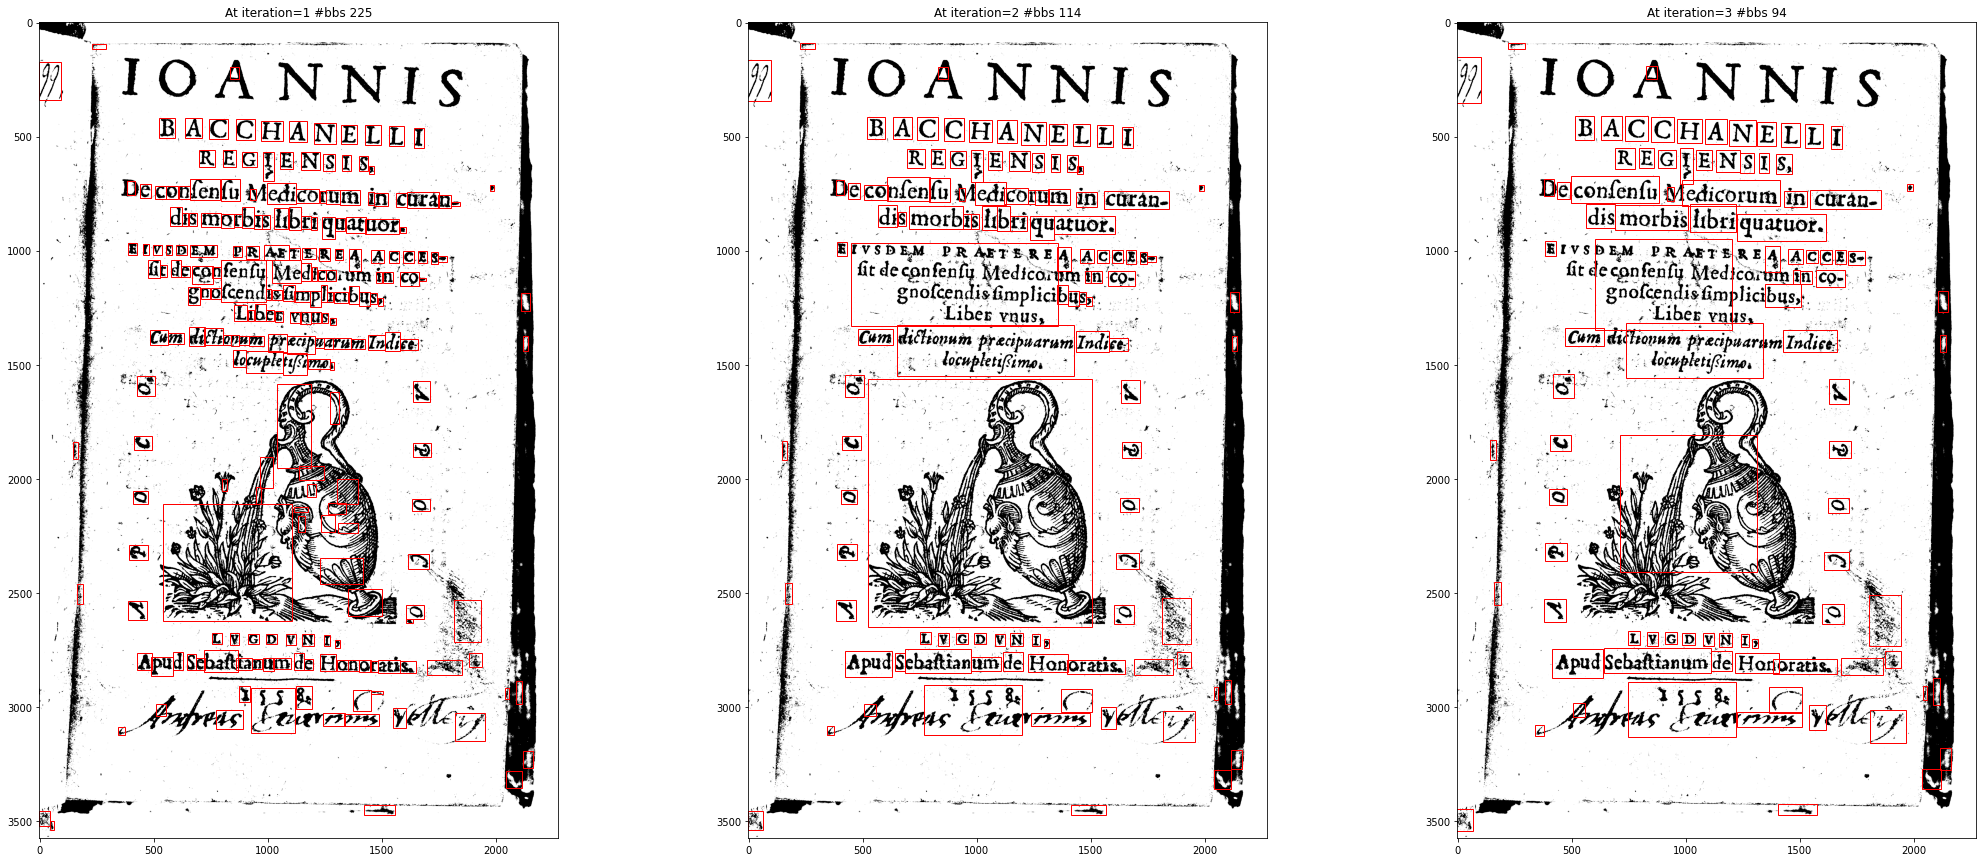

In [17]:
image = cv2.imread(train_path+'183786.png')
#image = cv2.imread(train_path+'194694.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

iterations = 3
dilation_d = 1.1
dilation_max = (300, 300)
intersection_threshold = 0.1

bbs = get_text_region_proposals(image)
intermetiate_bbs = []
bbs_l = get_bounding_boxs_of_passages(bbs, iterations, intersection_threshold, dilation_d, 
                                    dilation_max, intermetiate_bbs)
plot_intermediate_bbs(intermetiate_bbs, iterations)

## Find the proposal box for non-handwritten part

In [43]:
def segmentation(path, id, test_coordinates):
    image = cv2.imread(path+'/'+str(id)+'.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    iterations = 3
    dilation_d = 1.1
    dilation_max = (300, 300)
    intersection_threshold = 0.1

    bbs = get_text_region_proposals(image)
    intermetiate_bbs = []
    bbs_l = get_bounding_boxs_of_passages(bbs, iterations, intersection_threshold, dilation_d, 
                                        dilation_max, intermetiate_bbs)
    test_coordinates[int(id)] = intermetiate_bbs[-1]
    return test_coordinates

In [44]:
def save_coord(path, id, name):
    new_test_coordinates_l = {}
    for j in id:
        i = j.split('.')[0]
        new_test_coordinates = segmentation(path, i, new_test_coordinates_l)
        b = []
        for j in new_test_coordinates[int(i)]:
            a = []
            for k in j:
                a.append(int(k))
            b.append(a)
        new_test_coordinates_l[int(i)] = b

    with open(name, 'w') as f:
        json.dump(new_test_coordinates_l, f)

In [ ]:
train_dir = './train/train_image'
test_dir = './test/test_image'
train_id = sorted(os.listdir(train_dir))
test_id = sorted(os.listdir(test_dir))
train_name = 'train_0_coordinates.json'
test_name = 'test_0_coordinates.json'
save_coord(train_dir, train_id, train_name)
save_coord(test_dir, test_id, test_name)

## Save the non-handwritten part coordinate information

In [49]:
with open('train_0_coordinates.json') as f:
    train_0_coordinates = json.load(f)

with open('test_0_coordinates.json') as f:
    test_0_coordinates = json.load(f)

with open('train_coordinates.json') as f:
    train_coordinates = json.load(f)

with open('test_coordinates.json') as f:
    test_coordinates = json.load(f)

train_0 = {}
for i in train_0_coordinates.keys():
    train_0[i] = []

test_0 = {}
for i in test_0_coordinates.keys():
    test_0[i] = []

In [50]:
def get_IOU(bb1, bb2):
    # Finding intersection
    a, b = bb2[0]+bb2[2], bb2[1]+bb2[3]
    x_left = max(bb1[0], bb2[0])
    y_bottom = max(bb1[1], bb2[1])
    x_right = min(bb1[2], a)
    y_top = min(bb1[3], b)
    
    # Checking whether there is any intersection avaiable
    # If not, return area of intersection as 0.
    if (x_left > x_right) or (y_bottom > y_top):
        return 0.0

    area_intersect = (x_right - x_left) * (y_top - y_bottom)
    
    # To bring into percentage, calculate area of each bounding box
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = bb2[2] * bb2[3]
    total_area = bb1_area + bb2_area - area_intersect
    iou = area_intersect / total_area
    
    return iou

In [51]:
def get_0(t1_c, t0_c, t0):
    for i in t1_c.keys():
        for k in t0_c[i]:
            if len(t0[i]) <= 3:
                iou = 0
                for j in t1_c[i]:
                    iou += get_IOU(j, k)
                if iou/len(j) == 0 and (k[3] > 60 and k[2] > 60):
                    t0[i].append(k)

In [52]:
get_0(train_coordinates, train_0_coordinates, train_0)
get_0(test_coordinates, test_0_coordinates, test_0)

In [55]:
with open('train_0.json', 'w') as f:
    json.dump(train_0, f)

with open('test_0.json', 'w') as f:
    json.dump(test_0, f)

## Segmentation for non-handwritten part

In [83]:
train_cut_dir = './train/train0_cut/'
test_cut_dir = './test/test0_cut/'
train_0_dir = './train/train_0'
test_0_dir = './test/test_0'
train0_cut, test0_cut = {}, {}

In [84]:
def cut_image(path1, path2, cut, coordinates, file):
    for i in coordinates.keys():
        img_path = path1+'/'+i+'.png'
        im = cv2.imread(img_path)
    
        a = 0
        for j in coordinates[str(i)]:
            #if len(coordinates[str(i)]) > 0:
            b, c = j[1]+j[3], j[0]+j[2]
            if j[1] < 0:
                j[1] = 0
            if j[0] < 0:
                j[0] = 0
            name = i+'_'+str(a)
            b, c = j[1]+j[3], j[0]+j[2]
            ims = im[j[1]:b, j[0]:c]
            cut[name] = [int(j[2]), int(j[3])]
            cv2.imwrite(path2+name+'.png', ims)
            a += 1

    with open(file, 'w') as f:
        json.dump(cut, f)


In [85]:
cut_image(train_dir, train_cut_dir, train0_cut, train_0, 'train0_cut_shape.json')
cut_image(test_dir, test_cut_dir, test0_cut, test_0, 'test0_cut_shape.json')

## Cut the non-handwritten part and save its shape information

In [70]:
def pre_data(path1, path2, j):
    img = cv2.imread(path1+j+'.png')
    kernel = np.ones((2, 2), np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    #closing = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)
    if (opening.shape[0]>=opening.shape[1] and (opening.shape[0]/opening.shape[1])<=2.1) or (opening.shape[0]<=opening.shape[1] and (opening.shape[1]/opening.shape[0])<=2.1):
        resized_image = cv2.resize(opening, (227, 227))
        cv2.imwrite(path2+j+'_'+'_0.png', resized_image)
    elif opening.shape[0]>opening.shape[1] and (opening.shape[0]/opening.shape[1])>2.1:
        n = int(opening.shape[0] / opening.shape[1])
        dis_h = int(np.floor(opening.shape[0] / n))
        for i in range(n):
            a = i+1
            sub = opening[i*dis_h:(i+1)*dis_h, 0:opening.shape[1]]
            resized_image = cv2.resize(sub, (227, 227))
            cv2.imwrite(path2+j+'_'+str(a)+'_0.png', resized_image)
    elif opening.shape[0]<opening.shape[1] and (opening.shape[1]/opening.shape[0])>2.1:
        n = int(opening.shape[1] / opening.shape[0])
        dis_w = int(np.floor(opening.shape[1] / n))
        for i in range(n):
            a = i+1
            sub = opening[0:opening.shape[0], i*dis_w:(i+1)*dis_w]
            resized_image = cv2.resize(sub, (227, 227))
            cv2.imwrite(path2+j+'_'+str(a)+'_0.png', resized_image)
    print(j)

In [ ]:
train0_dir = './train/train_0/'
test0_dir = './test/test_0/'

with open('train0_cut_shape.json') as f:
    train0_cut = json.load(f)

with open('test0_cut_shape.json') as f:
    test0_cut = json.load(f)

for j in train0_cut.keys():
    pre_data(train_cut_dir, train0_dir, j)

for j in test0_cut.keys():
    pre_data(test_cut_dir, test0_dir, j)